In [288]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
import re
from geopy.geocoders import Nominatim
from geopy import distance
import holidays

In [289]:
completed_orders = pd.read_csv('../data/nb.csv')
delivery_requests = pd.read_csv('../data/driver_locations_during_request.csv')

In [290]:
delivery_requests.head()

,id,order_id,driver_id,driver_action,lat,lng,created_at,updated_at
0,1,392001,243828,accepted,6.602207,3.270465,NaN,NaN
1,2,392001,243588,rejected,6.592097,3.287445,NaN,NaN
2,3,392001,243830,rejected,6.596133,3.281784,NaN,NaN
3,4,392001,243539,rejected,6.596142,3.280526,NaN,NaN
4,5,392001,171653,rejected,6.609232,3.288800,NaN,NaN


In [291]:
delivery_requests.shape

(1557740, 8)

In [292]:
delivery_requests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id             1557740 non-null  int64  
 1   order_id       1557740 non-null  int64  
 2   driver_id      1557740 non-null  int64  
 3   driver_action  1557740 non-null  object 
 4   lat            1557740 non-null  float64
 5   lng            1557740 non-null  float64
 6   created_at     0 non-null        float64
 7   updated_at     0 non-null        float64
dtypes: float64(4), int64(3), object(1)
memory usage: 95.1+ MB


In [293]:
delivery_requests.isna().sum()

id                     0
order_id               0
driver_id              0
driver_action          0
lat                    0
lng                    0
created_at       1557740
updated_at       1557740
dtype: int64

delete the columns created_at and updated_at because there is no data found in them

In [294]:
delivery_requests.drop(columns=['created_at'], inplace=True)
delivery_requests.drop(columns=['updated_at'], inplace=True)

In [295]:
delivery_requests.isna().sum()

id               0
order_id         0
driver_id        0
driver_action    0
lat              0
lng              0
dtype: int64

In [296]:
grouped_delivery=delivery_requests.groupby(["order_id","driver_id","driver_action"],as_index=False).size()
grouped_delivery.head()

,order_id,driver_id,driver_action,size
0,392001,171651,rejected,1
1,392001,171653,rejected,1
2,392001,226949,rejected,1
3,392001,243539,rejected,1
4,392001,243588,rejected,1


In [297]:
grouped_delivery_new=grouped_delivery.groupby(["order_id","driver_action"],as_index=False).size()


grouped_delivery_new.rename(columns={"size":"count"},inplace=True)
grouped_delivery_new.head()


,order_id,driver_action,count
0,392001,accepted,1
1,392001,rejected,9
2,392005,accepted,1
3,392005,rejected,17
4,392009,accepted,1


In [298]:
accepted_orders=grouped_delivery_new[grouped_delivery_new["driver_action"]=="accepted"]
rejected_orders=grouped_delivery_new[~grouped_delivery_new.order_id.isin(accepted_orders.order_id)]

In [299]:
accepted_orders.head()

,order_id,driver_action,count
0,392001,accepted,1
2,392005,accepted,1
4,392009,accepted,1
6,392013,accepted,1
8,392014,accepted,1


In [300]:
rejected_orders.head()

,order_id,driver_action,count
1216,393128,rejected,32
1269,393177,rejected,16
1407,393291,rejected,2
1917,393737,rejected,9
1990,393809,rejected,14


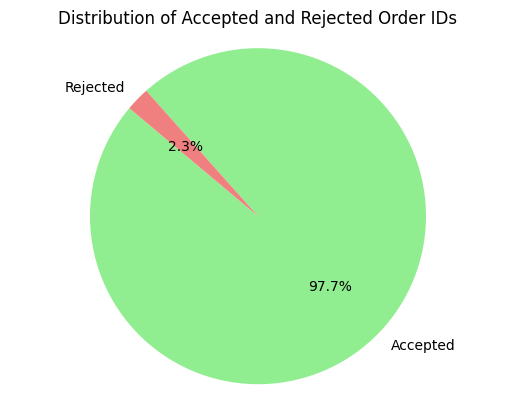

In [301]:
import matplotlib.pyplot as plt

# Assuming you have the DataFrames accepted_orders and rejected_orders as shown in your example

# Counting the number of unique order IDs for accepted and rejected orders
accepted_order_count = accepted_orders['order_id'].nunique()
rejected_order_count = rejected_orders['order_id'].nunique()

# Pie chart labels
labels = ['Accepted', 'Rejected']

# Pie chart data
sizes = [accepted_order_count, rejected_order_count]

# Pie chart colors
colors = ['lightgreen', 'lightcoral']

# Plotting the pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Adding a title
plt.title('Distribution of Accepted and Rejected Order IDs')

# Show plot
plt.show()


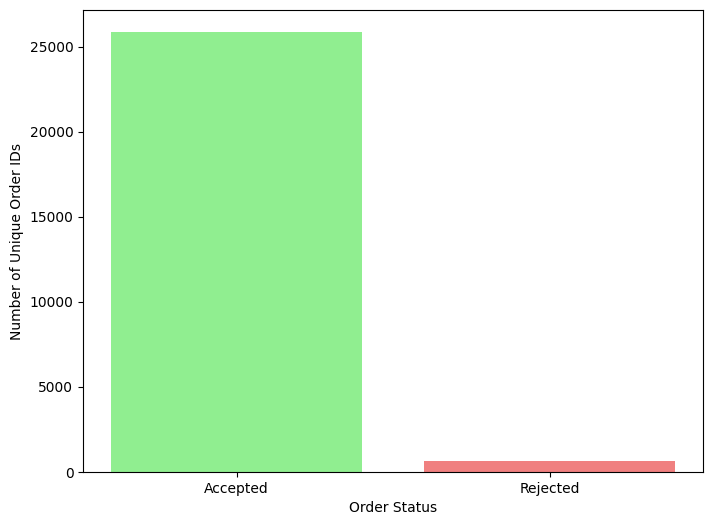

In [302]:
import matplotlib.pyplot as plt

# Assuming you have the DataFrames accepted_orders and rejected_orders as shown in your example

# Counting the number of unique order IDs for accepted and rejected orders
accepted_order_count = accepted_orders['order_id'].nunique()
rejected_order_count = rejected_orders['order_id'].nunique()

# Bar chart labels
labels = ['Accepted', 'Rejected']

# Bar chart data
counts = [accepted_order_count, rejected_order_count]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['lightgreen', 'lightcoral'])

# Adding labels and title
plt.xlabel('Order Status')
plt.ylabel('Number of Unique Order IDs')
plt.show()


merging the two datasets on order_id eqauls trip_id

In [303]:
completed_orders_cleaned = pd.read_csv('../data/completed_orders_cleaned2.csv')
completed_orders_cleaned.nunique()

trip_id             536020
trip_origin         112142
trip_destination    147520
trip_start_time     513611
trip_end_time       513855
duration_min         23205
distance            467322
holiday                  2
Day of Week              7
Hour of Day             24
dtype: int64

In [304]:
delivery_requests.nunique()

id               1557740
order_id           26492
driver_id           1213
driver_action          2
lat               194406
lng               170385
dtype: int64

In [305]:
completed_orders_useful_data = completed_orders_cleaned[["trip_id","trip_origin","trip_start_time","duration_min","holiday","Day of Week","Hour of Day"]]

In [306]:
lat = completed_orders_useful_data["trip_origin"].apply(lambda x:x.split(',')[0])
lon = completed_orders_useful_data["trip_origin"].apply(lambda x:x.split(',')[1])
completed_orders_useful_data['origin_lat'],completed_orders_useful_data['origin_lng']=lat,lon
completed_orders_useful_data.rename(columns={"trip_id":"order_id"},inplace=True)
completed_orders_useful_data.drop(columns="trip_origin",inplace=True)

/tmp/ipykernel_5248/2592935453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_orders_useful_data['origin_lat'],completed_orders_useful_data['origin_lng']=lat,lon
/tmp/ipykernel_5248/2592935453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_orders_useful_data['origin_lat'],completed_orders_useful_data['origin_lng']=lat,lon
/tmp/ipykernel_5248/2592935453.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

In [307]:
delivery_requests.rename(columns={"lat":"driver_lat","lng":"driver_lng"},inplace=True)

In [308]:
delivery_requests.to_csv("../data/delivery_requests_cleaned.csv",index=False)

In [309]:
merged_dataframe = delivery_requests.merge(completed_orders_useful_data,on="order_id")
merged_dataframe.to_csv("../data/merged_dataframe.csv",index=False)

In [310]:
merged_df = pd.read_csv('../data/merged_dataframe.csv')
merged_df.head

<bound method NDFrame.head of               id  order_id  driver_id driver_action  driver_lat  driver_lng  \
0              1    392001     243828      accepted    6.602207    3.270465   
1              2    392001     243588      rejected    6.592097    3.287445   
2              3    392001     243830      rejected    6.596133    3.281784   
3              4    392001     243539      rejected    6.596142    3.280526   
4              5    392001     171653      rejected    6.609232    3.288800   
...          ...       ...        ...           ...         ...         ...   
1557735  1557736    517948     243774      rejected    6.469036    3.566877   
1557736  1557737    517948     245447      rejected    6.425431    3.527358   
1557737  1557738    517948     239866      rejected    6.440013    3.525378   
1557738  1557739    517948     243774      rejected    6.469036    3.566877   
1557739  1557740    517948     244170      rejected    6.469390    3.572079   

             trip_sta

In [311]:
delivery_requests_new=delivery_requests.groupby(["order_id","driver_action"],as_index=False).agg(
    {
        "driver_id":"count",
        "driver_lat":"mean",
        "driver_lng":"mean",
    }
    )

In [312]:
delivery_requests_new

,order_id,driver_action,driver_id,driver_lat,driver_lng
0,392001,accepted,1,6.602207,3.270465
1,392001,rejected,9,6.602246,3.280118
2,392005,accepted,1,6.549147,3.392184
3,392005,rejected,50,6.566354,3.376415
4,392009,accepted,1,6.644829,3.289328
...,...,...,...,...,...
51243,497721,rejected,2,6.476228,3.374449
51244,510268,accepted,1,6.462251,3.391023
51245,510268,rejected,3,6.442820,3.418730
51246,517948,accepted,1,6.464150,3.552330


In [313]:
accepted_delivery_orders=delivery_requests_new[delivery_requests_new["driver_action"]=="accepted"]
rejected_delivery_orders=delivery_requests_new[~delivery_requests_new.order_id.isin(accepted_orders.order_id)]

In [314]:
accepted_delivery_orders

,order_id,driver_action,driver_id,driver_lat,driver_lng
0,392001,accepted,1,6.602207,3.270465
2,392005,accepted,1,6.549147,3.392184
4,392009,accepted,1,6.644829,3.289328
6,392013,accepted,1,6.435331,3.424317
8,392014,accepted,1,6.498221,3.360042
...,...,...,...,...,...
51238,489898,accepted,1,6.443810,3.464208
51240,490008,accepted,1,6.448554,3.574380
51242,497721,accepted,1,6.498164,3.359964
51244,510268,accepted,1,6.462251,3.391023


In [315]:
rejected_delivery_orders

,order_id,driver_action,driver_id,driver_lat,driver_lng
1216,393128,rejected,249,6.448078,3.471102
1269,393177,rejected,53,6.433693,3.434249
1407,393291,rejected,2,6.472269,3.595364
1917,393737,rejected,34,6.581892,3.284952
1990,393809,rejected,14,6.432379,3.430111
...,...,...,...,...,...
50859,448163,rejected,50,6.548443,3.367682
50904,448206,rejected,45,6.629031,3.349366
50929,448235,rejected,345,6.599802,3.335208
51067,448373,rejected,30,6.589903,3.346469


In [316]:
# Assuming accepted_delivery_orders and rejected_delivery_orders are DataFrame objects
unique_delivery_orders = pd.concat([accepted_delivery_orders, rejected_delivery_orders])

# Now you can proceed with your merging and renaming operations
clean_merged_df = unique_delivery_orders.merge(completed_orders_useful_data, on="order_id")
clean_merged_df.rename(columns={"driver_id": "action_count"}, inplace=True)

In [317]:
clean_merged_df

,order_id,driver_action,action_count,driver_lat,driver_lng,trip_start_time,duration_min,holiday,Day of Week,Hour of Day,origin_lat,origin_lng
0,392001,accepted,1,6.602207,3.270465,2021-07-01 09:30:59,3.616667,False,Thursday,9,6.6010417,3.2766339
1,392005,accepted,1,6.549147,3.392184,2021-07-01 10:53:36,34.250000,False,Thursday,10,6.565087699999999,3.3844415
2,392009,accepted,1,6.644829,3.289328,2021-07-01 06:39:51,61.350000,False,Thursday,6,6.6636484,3.3082058
3,392013,accepted,1,6.435331,3.424317,2021-07-01 08:44:09,35.033333,False,Thursday,8,6.4308171,3.4341552
4,392014,accepted,1,6.498221,3.360042,2021-07-01 06:43:07,44.283333,False,Thursday,6,6.499156300000001,3.3585173
...,...,...,...,...,...,...,...,...,...,...,...,...
26487,448163,rejected,50,6.548443,3.367682,2021-07-09 20:10:45,30.700000,False,Friday,20,6.553579,3.3654461
26488,448206,rejected,45,6.629031,3.349366,2021-07-09 19:07:24,43.416667,False,Friday,19,6.630902699999999,3.342772099999999
26489,448235,rejected,345,6.599802,3.335208,2021-07-13 16:06:15,1.733333,False,Tuesday,16,6.6076335,3.322855
26490,448373,rejected,30,6.589903,3.346469,2021-07-09 19:18:47,78.933333,False,Friday,19,6.5844933,3.357566


In [318]:
import sys
sys.path.append("../scripts/")
from data_cleaning import CleanData
cleaner = CleanData()

In [319]:
clean_merged_df = cleaner.find_distance(clean_merged_df,distance_col_name="distance_diff",trip_origin_col_names=["driver_lat","driver_lng"],trip_destination_col_names=["origin_lat","origin_lng"])

In [320]:
clean_merged_df=clean_merged_df[["order_id","driver_lat","driver_lng","origin_lat","origin_lng","distance_diff","trip_start_time","duration_min","holiday","action_count","driver_action","Day of Week","Hour of Day"]]

if the delivery minute duration is greater than 5 minutes the order is fulfilled but if not the order is not fulfilled

In [321]:
clean_merged_df["fulfilled"] = (clean_merged_df["driver_action"] == "accepted") & (clean_merged_df["duration_min"] >=5)

/tmp/ipykernel_5248/2125998967.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_merged_df["fulfilled"] = (clean_merged_df["driver_action"] == "accepted") & (clean_merged_df["duration_min"] >=5)


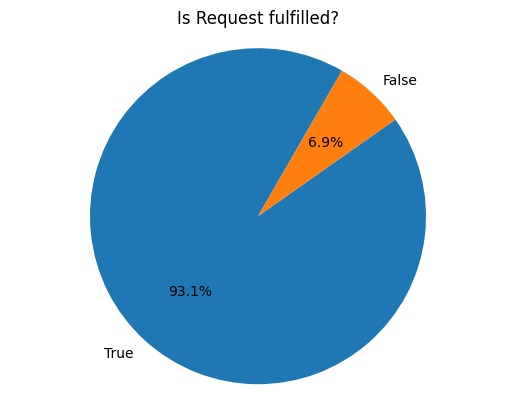

In [322]:
labels= clean_merged_df["fulfilled"].value_counts().index
sizes= ( clean_merged_df["fulfilled"].value_counts())

plt.pie(sizes,labels=labels,startangle=60, autopct='%1.1f%%')

plt.axis('equal')
plt.title("Is Request fulfilled?")

plt.show()

In [323]:
clean_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26492 entries, 0 to 26491
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_id         26492 non-null  int64  
 1   driver_lat       26492 non-null  float64
 2   driver_lng       26492 non-null  float64
 3   origin_lat       26492 non-null  object 
 4   origin_lng       26492 non-null  object 
 5   distance_diff    26492 non-null  float64
 6   trip_start_time  26492 non-null  object 
 7   duration_min     26492 non-null  float64
 8   holiday          26492 non-null  bool   
 9   action_count     26492 non-null  int64  
 10  driver_action    26492 non-null  object 
 11  Day of Week      26492 non-null  object 
 12  Hour of Day      26492 non-null  int64  
 13  fulfilled        26492 non-null  bool   
dtypes: bool(2), float64(4), int64(3), object(5)
memory usage: 2.5+ MB


In [324]:
clean_merged_df

,order_id,driver_lat,driver_lng,origin_lat,origin_lng,distance_diff,trip_start_time,duration_min,holiday,action_count,driver_action,Day of Week,Hour of Day,fulfilled
0,392001,6.602207,3.270465,6.6010417,3.2766339,0.694264,2021-07-01 09:30:59,3.616667,False,1,accepted,Thursday,9,False
1,392005,6.549147,3.392184,6.565087699999999,3.3844415,1.959786,2021-07-01 10:53:36,34.250000,False,1,accepted,Thursday,10,True
2,392009,6.644829,3.289328,6.6636484,3.3082058,2.947683,2021-07-01 06:39:51,61.350000,False,1,accepted,Thursday,6,True
3,392013,6.435331,3.424317,6.4308171,3.4341552,1.197389,2021-07-01 08:44:09,35.033333,False,1,accepted,Thursday,8,True
4,392014,6.498221,3.360042,6.499156300000001,3.3585173,0.197853,2021-07-01 06:43:07,44.283333,False,1,accepted,Thursday,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26487,448163,6.548443,3.367682,6.553579,3.3654461,0.619439,2021-07-09 20:10:45,30.700000,False,50,rejected,Friday,20,False
26488,448206,6.629031,3.349366,6.630902699999999,3.342772099999999,0.757986,2021-07-09 19:07:24,43.416667,False,45,rejected,Friday,19,False
26489,448235,6.599802,3.335208,6.6076335,3.322855,1.617454,2021-07-13 16:06:15,1.733333,False,345,rejected,Tuesday,16,False
26490,448373,6.589903,3.346469,6.5844933,3.357566,1.365251,2021-07-09 19:18:47,78.933333,False,30,rejected,Friday,19,False


handling outliers

In [325]:
Q1 = clean_merged_df['duration_min'].quantile(0.25)
Q3 = clean_merged_df['duration_min'].quantile(0.75)
IQR = Q3 - Q1

# Define the threshold for considering values as outliers
threshold = 1.5

# Identify outliers
outliers = clean_merged_df[(clean_merged_df['duration_min'] < (Q1 - threshold * IQR)) | (clean_merged_df['duration_min'] > (Q3 + threshold * IQR))]

print("Number of outliers:", len(outliers))
print(outliers)


Number of outliers: 1346
       order_id  driver_lat  driver_lng         origin_lat  \
7        392021    6.595759    3.288074          6.5943334   
16       392040    6.500949    3.583668  6.500608199999999   
52       392116    6.594403    3.341211  6.587144320851279   
62       392138    6.458376    3.271094          6.4488667   
197      392399    6.624827    3.263846          6.6223452   
...         ...         ...         ...                ...   
26406    432715    6.592169    3.406351  6.600270699999999   
26416    435601    6.569538    3.266494          6.5569346   
26426    437895    6.720626    3.399670          6.7156816   
26430    438262    6.557266    3.358543  6.563650000000001   
26486    448076    6.634033    3.349620  6.635186300000001   

               origin_lng  distance_diff      trip_start_time  duration_min  \
7               3.3007843       1.414449  2021-07-01 07:11:36    170.166667   
16              3.5981937       1.607153  2021-07-01 10:15:03    216.966

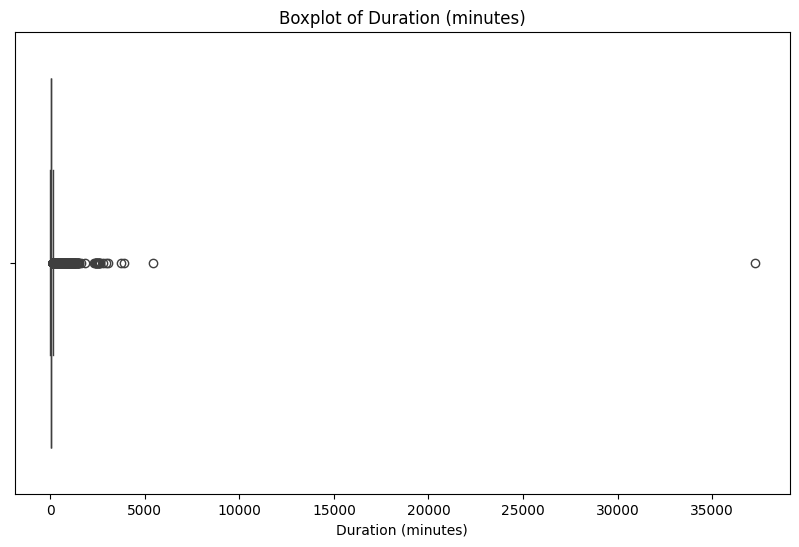

In [326]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
plt.figure(figsize=(10, 6))
sns.boxplot(x=clean_merged_df['duration_min'])
plt.title('Boxplot of Duration (minutes)')
plt.xlabel('Duration (minutes)')
plt.show()

remove the outliers

In [327]:
# Calculate the interquartile range (IQR)
Q1 = clean_merged_df['duration_min'].quantile(0.25)
Q3 = clean_merged_df['duration_min'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to exclude outliers
filtered_df = clean_merged_df[(clean_merged_df['duration_min'] >= lower_bound) & (clean_merged_df['duration_min'] <= upper_bound)]

# Print the number of rows removed
print("Number of outliers removed:", len(clean_merged_df) - len(filtered_df))

# Optionally, you can reset the index of the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)


Number of outliers removed: 1346


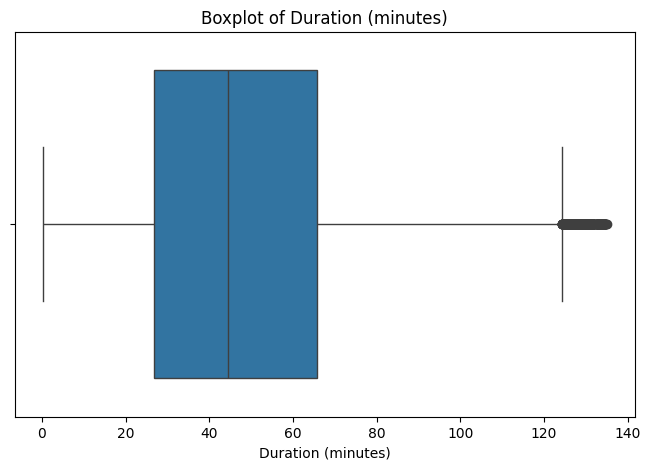

In [328]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
plt.figure(figsize=(8, 5))
sns.boxplot(x=filtered_df['duration_min'])
plt.title('Boxplot of Duration (minutes)')
plt.xlabel('Duration (minutes)')
plt.show()

In [329]:
accept_1km=filtered_df[(filtered_df["distance_diff"]<=1) & (filtered_df["driver_action"]=="accepted")].shape[0]
reject_1km=filtered_df[(filtered_df["distance_diff"]<=1) & (filtered_df["driver_action"]=="rejected")].shape[0]

In [330]:
accept_more_1km=filtered_df[(clean_merged_df["distance_diff"]>1) & (filtered_df["driver_action"]=="accepted")].shape[0]
reject_more_1km=filtered_df[(filtered_df["distance_diff"]>1) & (filtered_df["driver_action"]=="rejected")].shape[0]

/tmp/ipykernel_5248/3281924105.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  accept_more_1km=filtered_df[(clean_merged_df["distance_diff"]>1) & (filtered_df["driver_action"]=="accepted")].shape[0]


In [331]:
print(f"{accept_1km} requests were accepted by drivers within 1km while {reject_1km} were rejected within 1km radius")
print(f"{accept_more_1km} requests were accepted by drivers more than 1km while {reject_more_1km} were rejected more than 1km radius")


8113 requests were accepted by drivers within 1km while 347 were rejected within 1km radius
16468 requests were accepted by drivers more than 1km while 234 were rejected more than 1km radius


In [332]:
acceptance_summary=pd.DataFrame(data=[[accept_1km,reject_1km],[accept_more_1km,reject_more_1km]],columns=["accepted","rejected"],index=["with in 1km","more than 1km"])

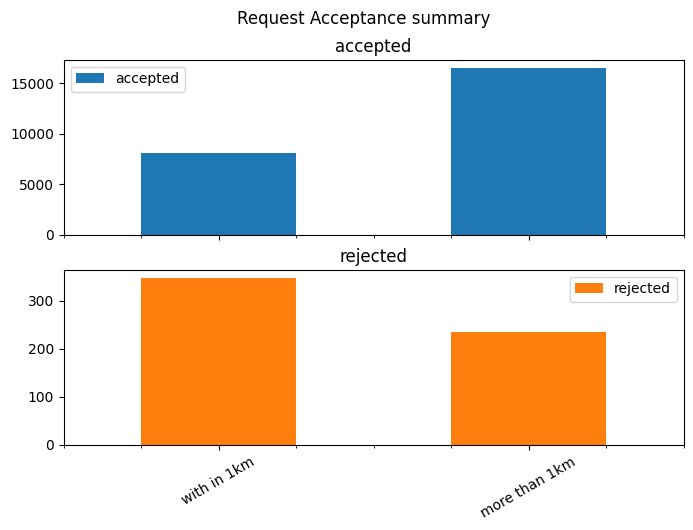

In [333]:
acceptance_summary.plot(kind='bar',subplots=True,rot=30,figsize=(8,5))
plt.suptitle("Request Acceptance summary")
plt.show()

In [334]:
clean_merged_df.to_csv("../data/merged_df_cleaned.csv",index=False)

In [335]:
filtered_df.nunique()

order_id           25146
driver_lat         24043
driver_lng         20405
origin_lat         14011
origin_lng         13937
distance_diff      25012
trip_start_time    23956
duration_min        6748
holiday                1
action_count         193
driver_action          2
Day of Week            7
Hour of Day           19
fulfilled              2
dtype: int64

In [336]:
# Assuming your DataFrame is named df
# Step 1: Map day names to weekdays (1) or weekends (0)
day_map = {
    'Monday': 1, 
    'Tuesday': 1, 
    'Wednesday': 1, 
    'Thursday': 1, 
    'Friday': 1,
    'Saturday': 0,
    'Sunday': 0
}
filtered_df['IsWeekend'] = filtered_df['Day of Week'].map(day_map)

# Step 2: Convert the mapped values to boolean
filtered_df['IsWeekend'] = filtered_df['IsWeekend'].astype(bool)

# Display the DataFrame with the new 'IsWeekend' column
print(filtered_df)


       order_id  driver_lat  driver_lng         origin_lat         origin_lng  \
0        392001    6.602207    3.270465          6.6010417          3.2766339   
1        392005    6.549147    3.392184  6.565087699999999          3.3844415   
2        392009    6.644829    3.289328          6.6636484          3.3082058   
3        392013    6.435331    3.424317          6.4308171          3.4341552   
4        392014    6.498221    3.360042  6.499156300000001          3.3585173   
...         ...         ...         ...                ...                ...   
25141    448163    6.548443    3.367682           6.553579          3.3654461   
25142    448206    6.629031    3.349366  6.630902699999999  3.342772099999999   
25143    448235    6.599802    3.335208          6.6076335           3.322855   
25144    448373    6.589903    3.346469          6.5844933           3.357566   
25145    448463    6.543287    3.379595          6.5398079          3.3869258   

       distance_diff      t

/tmp/ipykernel_5248/2954800480.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['IsWeekend'] = filtered_df['Day of Week'].map(day_map)
/tmp/ipykernel_5248/2954800480.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['IsWeekend'] = filtered_df['IsWeekend'].astype(bool)


In [337]:
filtered_df.nunique()

order_id           25146
driver_lat         24043
driver_lng         20405
origin_lat         14011
origin_lng         13937
distance_diff      25012
trip_start_time    23956
duration_min        6748
holiday                1
action_count         193
driver_action          2
Day of Week            7
Hour of Day           19
fulfilled              2
IsWeekend              2
dtype: int64

In [339]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25146 entries, 0 to 25145
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_id         25146 non-null  int64  
 1   driver_lat       25146 non-null  float64
 2   driver_lng       25146 non-null  float64
 3   origin_lat       25146 non-null  object 
 4   origin_lng       25146 non-null  object 
 5   distance_diff    25146 non-null  float64
 6   trip_start_time  25146 non-null  object 
 7   duration_min     25146 non-null  float64
 8   holiday          25146 non-null  bool   
 9   action_count     25146 non-null  int64  
 10  driver_action    25146 non-null  object 
 11  Day of Week      25146 non-null  object 
 12  Hour of Day      25146 non-null  int64  
 13  fulfilled        25146 non-null  bool   
 14  IsWeekend        25146 non-null  bool   
dtypes: bool(3), float64(4), int64(3), object(5)
memory usage: 2.4+ MB


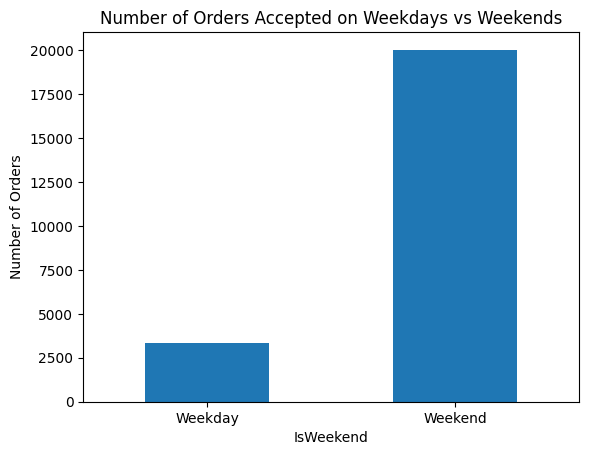

In [342]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter the DataFrame to include only fulfilled orders
fulfilled_orders_df = filtered_df[filtered_df['fulfilled']]

# Step 2: Group by 'IsWeekend' and count the number of orders
orders_by_weekend = fulfilled_orders_df.groupby('IsWeekend').size()

# Step 3: Plot the bar chart
orders_by_weekend.plot(kind='bar', rot=0)
plt.title('Number of Orders Accepted on Weekdays vs Weekends')
plt.xlabel('IsWeekend')
plt.ylabel('Number of Orders')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()
